# 1.准备数据
首先import必要的库，并加载sns内置数据集diamonds。

`diamonds`是Seaborn库中内置的一个数据集，它包含了关于钻石的各种属性和价格的信息。该数据集包含了53940个样本和10个特征，其中包括钻石的重量（carat）、切割质量（cut）、颜色（color）、净度（clarity）、尺寸（x、y、z）以及价格（price）等信息。这个数据集常用于数据可视化和机器学习任务中。

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


将非数值列标记为'category'类型


In [2]:
from sklearn.model_selection import train_test_split
X, y = diamonds.drop('price', axis=1), diamonds[['price']]
X.select_dtypes(exclude=np.number).astype('category')
X

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74


In [3]:
y

,price
0,326
1,326
2,327
3,334
4,335
...,...
53935,2757
53936,2757
53937,2757
53938,2757


将训练集和测试集分别封装为xgb.DMatrix。

`xgb.DMatrix` 是 XGBoost 中的数据结构，用于高效存储和处理训练和预测数据。封装为 `xgb.DMatrix` 可以提升性能、支持额外功能，并使数据格式一致，简化代码。这个封装还有助于在不同语言中使用 XGBoost。`enable_categorical=True` 表示启用对分类特征的支持。

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
import xgboost as xgb
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# 2.定义XGBoost模型，并训练、预测、评估。
定义了 XGBoost 模型的超参数，其中 `objective`设置为 "reg:squarederror" 表示回归问题，`tree_method` 设置为 "hist" 表示使用直方图算法进行训练。

使用 xgb.train 函数训练 XGBoost 模型，传递了设置好的超参数、训练数据集 (dtrain_reg) 和训练轮数 (num_boost_round=n)。最终得到了一个训练好的 XGBoost 模型 model。

In [5]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 100
model0 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
)

进行预测，并计算RMSE。

`squared=False`表示计算的是均方根误差而不是均方误差。

In [6]:
from sklearn.metrics import mean_squared_error
preds = model0.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 552.861


改进模型**model1**。传递了相同的超参数、训练数据集 `dtrain_reg`、训练轮数 `num_boost_round=n`、以及用于实时评估的数据集列表 `evals`。`verbose_eval=10`表示每隔 10 个轮次输出一次训练信息，`early_stopping_rounds=50` 表示如果连续 50 个轮次验证误差没有提升，就提前停止训练。

In [7]:

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
model1 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,
    early_stopping_rounds=50
)


[0]	train-rmse:2874.49146	validation-rmse:2817.90814
[10]	train-rmse:548.36512	validation-rmse:592.03160
[20]	train-rmse:491.09887	validation-rmse:558.53485
[30]	train-rmse:469.58201	validation-rmse:555.51015
[40]	train-rmse:454.32953	validation-rmse:554.45666
[50]	train-rmse:438.68033	validation-rmse:554.13365
[60]	train-rmse:425.38361	validation-rmse:551.57888
[70]	train-rmse:414.71115	validation-rmse:549.26109
[80]	train-rmse:405.41008	validation-rmse:549.03952
[90]	train-rmse:391.04269	validation-rmse:551.87206
[99]	train-rmse:383.48826	validation-rmse:552.86131


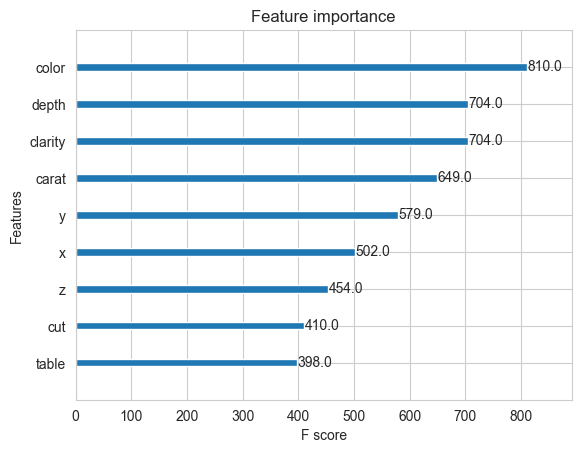

In [8]:
xgb.plot_importance(model1)
plt.show()

# 3. 准备数据
准备另一组数据，用于分类。标签是切割质量，采用有序编码。同样将训练集和测试集封装为xgb.DMatrix（）

In [9]:
from sklearn.preprocessing import OrdinalEncoder
X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]
y_encoded = OrdinalEncoder().fit_transform(y)
X.select_dtypes(exclude=np.number).astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [10]:
X

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [11]:
y

,cut
0,Ideal
1,Premium
2,Good
3,Premium
4,Good
...,...
53935,Ideal
53936,Good
53937,Very Good
53938,Premium


In [12]:
y_encoded

array([[2.],
       [3.],
       [1.],
       ...,
       [4.],
       [3.],
       [2.]])

# 4.定义，训练，预测，评估

In [13]:
params = {"objective": "multi:softprob", "tree_method": "hist", "num_class": 5}
n = 100
model2 = xgb.train(
    params=params,
    dtrain=dtrain_clf,
    num_boost_round=n,
    evals=[(dtrain_clf, 'train'), (dtest_clf, 'validation')],
    verbose_eval=10,
    early_stopping_rounds=20
)

[0]	train-mlogloss:1.25764	validation-mlogloss:1.26400
[10]	train-mlogloss:0.66235	validation-mlogloss:0.70094
[20]	train-mlogloss:0.57956	validation-mlogloss:0.63947
[30]	train-mlogloss:0.53409	validation-mlogloss:0.61022
[40]	train-mlogloss:0.49728	validation-mlogloss:0.58952
[50]	train-mlogloss:0.46532	validation-mlogloss:0.57336
[60]	train-mlogloss:0.44163	validation-mlogloss:0.56433
[70]	train-mlogloss:0.42124	validation-mlogloss:0.55776
[80]	train-mlogloss:0.40141	validation-mlogloss:0.55029
[90]	train-mlogloss:0.38308	validation-mlogloss:0.54501
[99]	train-mlogloss:0.36875	validation-mlogloss:0.54292


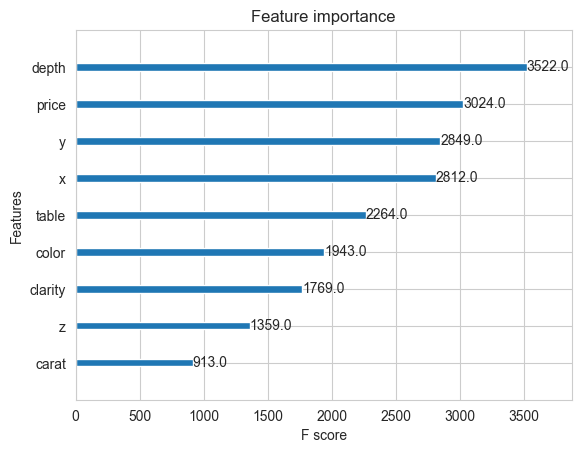

In [14]:
xgb.plot_importance(model2)
plt.show()

In [15]:
import xgboost as xgb

# Train a model using the scikit-learn API
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100, 
    objective='binary:logistic', 
    tree_method='hist', 
    eta=0.1,    
    max_depth=3, 
    enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

# Convert the model to a native API model
# model = xgb_classifier.get_booster()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

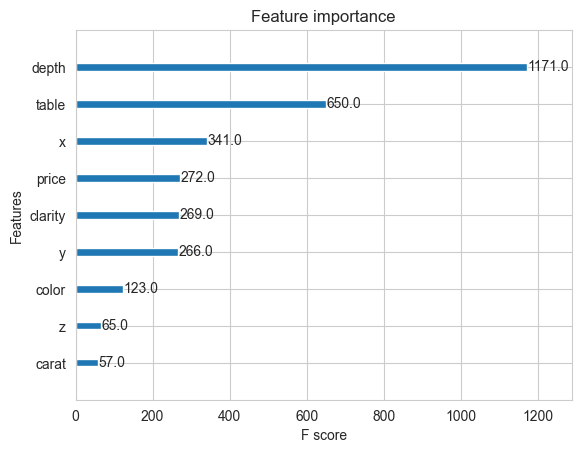

In [16]:
 
xgb.plot_importance(xgb_classifier)
plt.show()